<a href="https://colab.research.google.com/github/Alexis2411/Hadoop/blob/main/Tema1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-2.4.8/spark-2.4.8-bin-hadoop2.7.tgz
!tar xf spark-2.4.8-bin-hadoop2.7.tgz
!pip install -q findspark

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.8-bin-hadoop2.7"

In [3]:
!java --version

openjdk 11.0.15 2022-04-19
OpenJDK Runtime Environment (build 11.0.15+10-Ubuntu-0ubuntu0.18.04.1)
OpenJDK 64-Bit Server VM (build 11.0.15+10-Ubuntu-0ubuntu0.18.04.1, mixed mode, sharing)


In [4]:
!echo $JAVA_HOME

/usr/lib/jvm/java-8-openjdk-amd64


In [5]:
!echo $SPARK_HOME


/content/spark-2.4.8-bin-hadoop2.7


In [6]:
import findspark
findspark.init()
from google.colab import files
from pyspark import SparkContext, SparkConf,SQLContext,HiveContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, when, count, col, lit
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 

In [7]:
# create SparkSession
spark = SparkSession \
    .builder \
    .getOrCreate()

In [8]:
spark.version

'2.4.8'

In [9]:
sc = spark.sparkContext

In [10]:
sc.version

'2.4.8'

In [11]:
sqlContext = SQLContext(sc)

In [14]:
path_csv="/content/daily_weather.csv"
df = sqlContext.read.csv(path_csv,header=True,inferSchema=True)
df.show(10)

+------+-----------------+------------------+----------------------+------------------+----------------------+------------------+---------------------+-----------------+---------------------+---------------------+
|number| air_pressure_9am|      air_temp_9am|avg_wind_direction_9am|avg_wind_speed_9am|max_wind_direction_9am|max_wind_speed_9am|rain_accumulation_9am|rain_duration_9am|relative_humidity_9am|relative_humidity_3pm|
+------+-----------------+------------------+----------------------+------------------+----------------------+------------------+---------------------+-----------------+---------------------+---------------------+
|     0|918.0600000000087| 74.82200000000041|                 271.1| 2.080354199999768|    295.39999999999986| 2.863283199999908|                  0.0|              0.0|    42.42000000000046|   36.160000000000494|
|     1|917.3476881177097| 71.40384263106537|    101.93517935618371|2.4430092157340217|    140.47154847112498|3.5333236016106238|               

In [16]:
df.describe("number","air_pressure_9am","air_temp_9am","avg_wind_direction_9am","avg_wind_speed_9am","max_wind_direction_9am").show()

+-------+------------------+-----------------+------------------+----------------------+------------------+----------------------+
|summary|            number| air_pressure_9am|      air_temp_9am|avg_wind_direction_9am|avg_wind_speed_9am|max_wind_direction_9am|
+-------+------------------+-----------------+------------------+----------------------+------------------+----------------------+
|  count|              1095|             1092|              1090|                  1091|              1092|                  1092|
|   mean|             547.0|918.8825513138094| 64.93300141287072|     142.2355107005759|  5.50828424225493|    148.95351796516923|
| stddev|316.24357700987383|3.184161180386833|11.175514003175877|     69.13785928889189|4.5528134655317185|     67.23801294602953|
|    min|                 0|907.9900000000024|36.752000000000685|    15.500000000000046|  0.69345139999974|     28.89999999999991|
|    max|              1094|929.3200000000012| 98.90599999999992|                 3

In [17]:
df.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
number,1095,547.0,316.24357700987383,0,1094
air_pressure_9am,1092,918.8825513138094,3.184161180386833,907.9900000000024,929.3200000000012
air_temp_9am,1090,64.93300141287072,11.175514003175877,36.752000000000685,98.90599999999992
avg_wind_direction_9am,1091,142.2355107005759,69.13785928889189,15.500000000000046,343.4
avg_wind_speed_9am,1092,5.50828424225493,4.5528134655317185,0.69345139999974,23.554978199999763
max_wind_direction_9am,1092,148.95351796516923,67.23801294602953,28.89999999999991,312.19999999999993
max_wind_speed_9am,1091,7.019513529175272,5.598209170780958,1.1855782000000479,29.84077959999996
rain_accumulation_9am,1089,0.20307895225211126,1.5939521253574893,0.0,24.01999999999907
rain_duration_9am,1092,294.1080522756142,1598.0787786601481,0.0,17704.0


In [19]:
quantiles_air_pressure_9am = df.approxQuantile("air_pressure_9am",[0.25, 0.5, 0.75], 0)
quantile_25 = quantiles_air_pressure_9am [0]
quantile_50 = quantiles_air_pressure_9am [1]
quantile_75 = quantiles_air_pressure_9am [2]
print('quantile_25: '+str(quantile_25))
print('quantile_50: '+str(quantile_50))
print('quantile_75: '+str(quantile_75))

quantile_25: 916.550000000009
quantile_50: 918.9020905167166
quantile_75: 921.1600000000036


In [22]:
quantiles = df.approxQuantile(df.columns,[0.25, 0.5, 0.75], 0)
for i in range(len(df.columns)):
  print("Cuantiles " + str(df.columns[i]) + ": " + str(quantiles[0]))

Cuantiles number: [273.0, 547.0, 821.0]
Cuantiles air_pressure_9am: [273.0, 547.0, 821.0]
Cuantiles air_temp_9am: [273.0, 547.0, 821.0]
Cuantiles avg_wind_direction_9am: [273.0, 547.0, 821.0]
Cuantiles avg_wind_speed_9am: [273.0, 547.0, 821.0]
Cuantiles max_wind_direction_9am: [273.0, 547.0, 821.0]
Cuantiles max_wind_speed_9am: [273.0, 547.0, 821.0]
Cuantiles rain_accumulation_9am: [273.0, 547.0, 821.0]
Cuantiles rain_duration_9am: [273.0, 547.0, 821.0]
Cuantiles relative_humidity_9am: [273.0, 547.0, 821.0]
Cuantiles relative_humidity_3pm: [273.0, 547.0, 821.0]


In [23]:
pd.DataFrame(data=quantiles, index=df.columns,columns=[0.25, 0.5, 0.75])

,0.25,0.50,0.75
number,273.000000,547.000000,821.000000
air_pressure_9am,916.550000,918.902091,921.160000
air_temp_9am,57.272000,65.696000,73.454000
avg_wind_direction_9am,65.880616,166.000000,191.100000
avg_wind_speed_9am,2.248279,3.869906,7.337163
max_wind_direction_9am,76.456663,177.100000,201.200000
max_wind_speed_9am,3.064608,4.943637,8.970129
rain_accumulation_9am,0.000000,0.000000,0.000000
rain_duration_9am,0.000000,0.000000,0.000000
relative_humidity_9am,15.090000,23.179259,45.590000


In [24]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
df_dropped = df.na.drop()
df_dropped = df_dropped.drop("number")
df_columns2 = df_dropped.columns

In [25]:
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=df_dropped.columns,
outputCol=vector_col)
df_vector = assembler.transform(df_dropped).select(vector_col)

In [26]:
r1 = Correlation.corr(df_vector, vector_col)
print("Pearson Corr Matrix\n",r1.collect()[0]["pearson({})".format(vector_col)].values)

Pearson Corr Matrix
 [ 1.00000000e+00 -5.73292204e-02 -3.13359891e-01  2.35825512e-01
 -2.87280174e-01  2.52478957e-01 -8.54342968e-02 -1.00485493e-01
 -4.31125747e-01 -4.80116906e-01 -5.73292204e-02  1.00000000e+00
 -1.50692077e-02 -2.84327416e-01 -7.95195474e-02 -2.82482708e-01
 -1.99101681e-01 -2.59103491e-01 -5.82318141e-01 -4.91067617e-01
 -3.13359891e-01 -1.50692077e-02  1.00000000e+00 -4.41441220e-01
  8.68837152e-01 -4.60121988e-01  1.17634400e-01  1.27367460e-01
  3.46864506e-01  3.84884780e-01  2.35825512e-01 -2.84327416e-01
 -4.41441220e-01  1.00000000e+00 -3.64337598e-01  9.95412273e-01
  2.32227425e-03  1.20570209e-02 -9.54715676e-02 -1.54421685e-01
 -2.87280174e-01 -7.95195474e-02  8.68837152e-01 -3.64337598e-01
  1.00000000e+00 -3.83024562e-01  9.10027833e-02  8.25735465e-02
  3.69499831e-01  4.05946112e-01  2.52478957e-01 -2.82482708e-01
 -4.60121988e-01  9.95412273e-01 -3.83024562e-01  1.00000000e+00
 -3.34335330e-04  1.18900525e-02 -1.08672591e-01 -1.73719670e-01
 -8.

In [28]:
pearson_corr_arr = np.matrix(r1.collect()[0]["pearson({})".format(vector_col)].values).reshape(len(df.columns)-1, len(df.columns)-1)
pearson_corr_df = pd.DataFrame(data=pearson_corr_arr,
index=df_columns2,columns=df_columns2)
pearson_corr_df

,air_pressure_9am,air_temp_9am,avg_wind_direction_9am,avg_wind_speed_9am,max_wind_direction_9am,max_wind_speed_9am,rain_accumulation_9am,rain_duration_9am,relative_humidity_9am,relative_humidity_3pm
air_pressure_9am,1.000000,-0.057329,-0.313360,0.235826,-0.287280,0.252479,-0.085434,-0.100485,-0.431126,-0.480117
air_temp_9am,-0.057329,1.000000,-0.015069,-0.284327,-0.079520,-0.282483,-0.199102,-0.259103,-0.582318,-0.491068
avg_wind_direction_9am,-0.313360,-0.015069,1.000000,-0.441441,0.868837,-0.460122,0.117634,0.127367,0.346865,0.384885
avg_wind_speed_9am,0.235826,-0.284327,-0.441441,1.000000,-0.364338,0.995412,0.002322,0.012057,-0.095472,-0.154422
max_wind_direction_9am,-0.287280,-0.079520,0.868837,-0.364338,1.000000,-0.383025,0.091003,0.082574,0.369500,0.405946
max_wind_speed_9am,0.252479,-0.282483,-0.460122,0.995412,-0.383025,1.000000,-0.000334,0.011890,-0.108673,-0.173720
rain_accumulation_9am,-0.085434,-0.199102,0.117634,0.002322,0.091003,-0.000334,1.000000,0.735737,0.228951,0.181887
rain_duration_9am,-0.100485,-0.259103,0.127367,0.012057,0.082574,0.011890,0.735737,1.000000,0.304828,0.263283
relative_humidity_9am,-0.431126,-0.582318,0.346865,-0.095472,0.369500,-0.108673,0.228951,0.304828,1.000000,0.881301
relative_humidity_3pm,-0.480117,-0.491068,0.384885,-0.154422,0.405946,-0.173720,0.181887,0.263283,0.881301,1.000000


In [29]:
from pyspark.mllib.stat import Statistics
df_features = df.drop("number")
df_features = df.select(df_features.columns).dropna()

In [30]:
rdd_table = df_features.rdd.map(lambda row: row[0:])

In [31]:
corr_mat=Statistics.corr(rdd_table, method="pearson")
print(corr_mat)

[[ 1.00000000e+00 -5.73292204e-02 -3.13359891e-01  2.35825512e-01
  -2.87280174e-01  2.52478957e-01 -8.54342968e-02 -1.00485493e-01
  -4.31125747e-01 -4.80116906e-01]
 [-5.73292204e-02  1.00000000e+00 -1.50692077e-02 -2.84327416e-01
  -7.95195474e-02 -2.82482708e-01 -1.99101681e-01 -2.59103491e-01
  -5.82318141e-01 -4.91067617e-01]
 [-3.13359891e-01 -1.50692077e-02  1.00000000e+00 -4.41441220e-01
   8.68837152e-01 -4.60121988e-01  1.17634400e-01  1.27367460e-01
   3.46864506e-01  3.84884780e-01]
 [ 2.35825512e-01 -2.84327416e-01 -4.41441220e-01  1.00000000e+00
  -3.64337598e-01  9.95412273e-01  2.32227425e-03  1.20570209e-02
  -9.54715676e-02 -1.54421685e-01]
 [-2.87280174e-01 -7.95195474e-02  8.68837152e-01 -3.64337598e-01
   1.00000000e+00 -3.83024562e-01  9.10027833e-02  8.25735465e-02
   3.69499831e-01  4.05946112e-01]
 [ 2.52478957e-01 -2.82482708e-01 -4.60121988e-01  9.95412273e-01
  -3.83024562e-01  1.00000000e+00 -3.34335330e-04  1.18900525e-02
  -1.08672591e-01 -1.73719670e-01

In [32]:
corr_mat_pd_pearson = pd.DataFrame(data=corr_mat,
index=df_features.columns,columns=df_features.columns)
corr_mat_pd_pearson

,air_pressure_9am,air_temp_9am,avg_wind_direction_9am,avg_wind_speed_9am,max_wind_direction_9am,max_wind_speed_9am,rain_accumulation_9am,rain_duration_9am,relative_humidity_9am,relative_humidity_3pm
air_pressure_9am,1.000000,-0.057329,-0.313360,0.235826,-0.287280,0.252479,-0.085434,-0.100485,-0.431126,-0.480117
air_temp_9am,-0.057329,1.000000,-0.015069,-0.284327,-0.079520,-0.282483,-0.199102,-0.259103,-0.582318,-0.491068
avg_wind_direction_9am,-0.313360,-0.015069,1.000000,-0.441441,0.868837,-0.460122,0.117634,0.127367,0.346865,0.384885
avg_wind_speed_9am,0.235826,-0.284327,-0.441441,1.000000,-0.364338,0.995412,0.002322,0.012057,-0.095472,-0.154422
max_wind_direction_9am,-0.287280,-0.079520,0.868837,-0.364338,1.000000,-0.383025,0.091003,0.082574,0.369500,0.405946
max_wind_speed_9am,0.252479,-0.282483,-0.460122,0.995412,-0.383025,1.000000,-0.000334,0.011890,-0.108673,-0.173720
rain_accumulation_9am,-0.085434,-0.199102,0.117634,0.002322,0.091003,-0.000334,1.000000,0.735737,0.228951,0.181887
rain_duration_9am,-0.100485,-0.259103,0.127367,0.012057,0.082574,0.011890,0.735737,1.000000,0.304828,0.263283
relative_humidity_9am,-0.431126,-0.582318,0.346865,-0.095472,0.369500,-0.108673,0.228951,0.304828,1.000000,0.881301
relative_humidity_3pm,-0.480117,-0.491068,0.384885,-0.154422,0.405946,-0.173720,0.181887,0.263283,0.881301,1.000000


In [33]:
corr_mat_sp=Statistics.corr(rdd_table, method="spearman")
corr_mat_pd_sp = pd.DataFrame(data=corr_mat_sp,
index=df_features.columns,columns=df_features.columns)
corr_mat_pd_sp

,air_pressure_9am,air_temp_9am,avg_wind_direction_9am,avg_wind_speed_9am,max_wind_direction_9am,max_wind_speed_9am,rain_accumulation_9am,rain_duration_9am,relative_humidity_9am,relative_humidity_3pm
air_pressure_9am,1.000000,-0.117418,-0.279479,0.232753,-0.243158,0.248009,-0.063062,0.000697,-0.472377,-0.527897
air_temp_9am,-0.117418,1.000000,0.021986,-0.360481,-0.040398,-0.364843,-0.227157,-0.286164,-0.424956,-0.359926
avg_wind_direction_9am,-0.279479,0.021986,1.000000,-0.377934,0.859601,-0.392063,0.142616,0.039965,0.335965,0.408805
avg_wind_speed_9am,0.232753,-0.360481,-0.377934,1.000000,-0.299334,0.993435,0.082594,0.210421,-0.105392,-0.205306
max_wind_direction_9am,-0.243158,-0.040398,0.859601,-0.299334,1.000000,-0.309779,0.129086,0.043627,0.336457,0.394171
max_wind_speed_9am,0.248009,-0.364843,-0.392063,0.993435,-0.309779,1.000000,0.080661,0.212161,-0.112784,-0.218481
rain_accumulation_9am,-0.063062,-0.227157,0.142616,0.082594,0.129086,0.080661,1.000000,0.846628,0.286516,0.238172
rain_duration_9am,0.000697,-0.286164,0.039965,0.210421,0.043627,0.212161,0.846628,1.000000,0.206381,0.150008
relative_humidity_9am,-0.472377,-0.424956,0.335965,-0.105392,0.336457,-0.112784,0.286516,0.206381,1.000000,0.866784
relative_humidity_3pm,-0.527897,-0.359926,0.408805,-0.205306,0.394171,-0.218481,0.238172,0.150008,0.866784,1.000000


In [34]:
import plotly.express as px
fig = px.imshow(pearson_corr_arr)
fig.show()

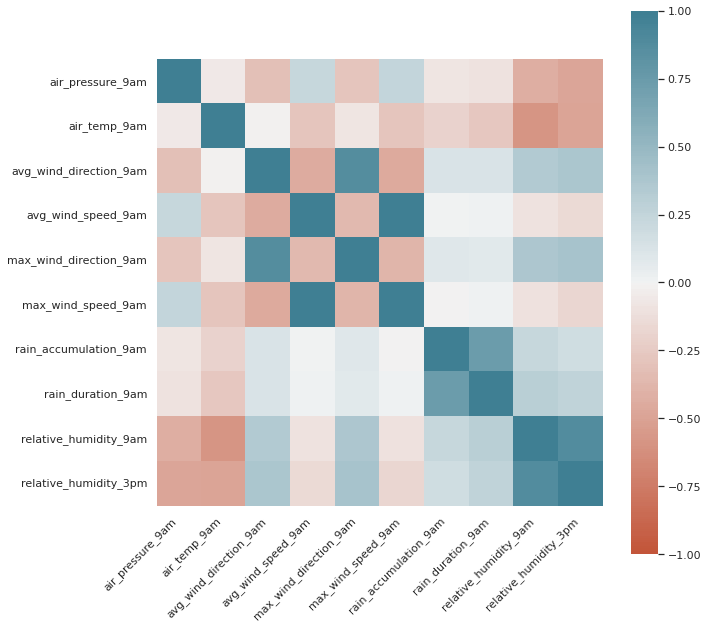

In [35]:
import seaborn as sns
sns.set(color_codes=True, font_scale=1.0)
from matplotlib import pyplot as plt
#Establecer el tamaño de la figura
plt.figure(figsize=(10,10))
ax = sns.heatmap(
pearson_corr_df,
vmin=-1, vmax=1, center=0,
cmap=sns.diverging_palette(20, 220, n=200),
square=True
)
#La barra de anotación
ax.set_xticklabels(
ax.get_xticklabels(),
rotation=45,
horizontalalignment='right'
);

In [36]:
!pip install heatmapz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


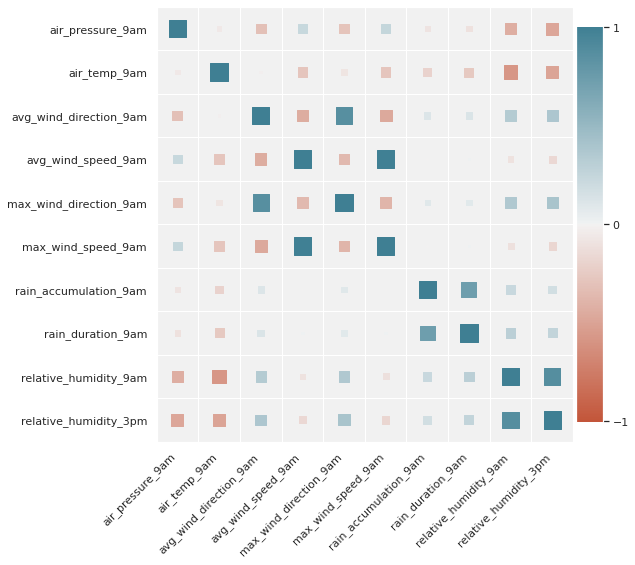

In [37]:
from heatmap import corrplot
plt.figure(figsize=(8, 8))
corrplot(pearson_corr_df ,size_scale=300);